# Start

In [1]:
import importlib
import os
import sys
import csv
import datetime 
import json
import importlib.util
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from pathlib import Path
from docx import Document
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.shared import Inches
from typing import Optional
import seaborn as sns
import re
from IPython.display import Image, display

from langchain_core.tools import Tool, StructuredTool
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage

from bsm_multi_agents.graph.state import WorkflowState

In [2]:
cwd = Path.cwd()
project_path = cwd.parent.parent
os.chdir(project_path)
project_path

PosixPath('/Users/yifanli/Github/model_doc_automation/TooTwo_mcp')

In [3]:
server_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
csv_file_path = os.path.join(project_path, "data/input/simulated_equity_options.csv")
output_dir = os.path.join(project_path, "data/cache")
local_tool_folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")
final_report_path = os.path.join(project_path, "data/output/final_report.docx")

In [4]:
def _print_debug_summary(content: str):
    """Helper to print generated summary for debugging (simulating paragraph structure)"""
    print(f"\n{'='*80}")
    
    blocks = content.split("\n\n")
    for i, block in enumerate(blocks):
        clean_block = block.strip()
        if clean_block:
            print(f"[Paragraph {i+1}]:")
            print(clean_block)
            print("-" * 40)
            
    print(f"{'='*80}\n")

# LLM

In [6]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [7]:
llm = get_llm()

llm.invoke("Hello, how are you?")

AIMessage(content=[{'type': 'text', 'text': "Hello! I'm doing well, thank you for asking. How are you doing today? Is there anything I can help you with?", 'extras': {'signature': 'EuICCt8CAXLI2nztpT2SipZggZYMWBx/gvpxa+nw4JpD0QvDkngNrGp0/J/F049hAvMT+443V6NXzy8pJKjtTruzut4GLsrDUYc3zXuQ9E7zOGqykphM0Dx7A5+sbCs/C6JxwMcVg3uCkoGNa/Zlha5Gi4f/873JbkEmdFeMVLLqSTTQ55QZR7gXKJVOmM4FQkoKudLKlhBsDPOEnQB6/F6L3EOkT4bxZNsMnriIT3CRapOvuF5JEyLIOifoHKrjLFqIdSjELr3AfsSFUCpT5BujsXsll8C4pcgkmvXPI+4qYCTEd6Sbh/PqM0oiHSLhhymTYBpoQyZ4WJiLRYm47ZbGfRe4DR+ROMv9qohBRZwULp+WtFwUN2450323aaae8k/yJtKJjV7/X+Y8FcFgMMfYrOuNOLX2oVzTx+A2RosV9JpctueaFuJLNlRjCjhnKGzIHbwT1Nfifm7KLXrabT9ao8zi'}}], additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-flash-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019b99ff-c1fb-7752-b2fa-ce64a3dc55a5-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 7, 'output_tokens': 112, 'total_tokens': 119, 'inpu

In [8]:
api_key = os.getenv("GOOGLE_API_KEY")
api_key

# MCP Server

## call_mcp_tool_async

In [19]:
from bsm_multi_agents.agents.mcp_adapter import call_mcp_tool

In [ ]:
tool_name = "calculate_bsm_to_file"
args = {
    "input_path": csv_file_path,
    "output_dir": output_dir,
}

In [21]:
call_mcp_tool(tool_name, server_script_path, args)

CallToolResult(meta=None, content=[TextContent(type='text', text='Unknown tool: calculate_bsm_to_file', annotations=None, meta=None)], structuredContent=None, isError=True)

## list_mcp_tools_sync

In [22]:
from bsm_multi_agents.agents.mcp_adapter import list_mcp_tools_sync

In [23]:
server_script_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")

In [24]:
list_mcp_tools_sync(server_script_path)

[Tool(name='calculate_greeks_to_file', title=None, description='\n    Reads the CSV at input_path, calculates greeks, and saves the result to output_dir.\n    Returns the path to the result file.\n    ', inputSchema={'properties': {'input_path': {'title': 'Input Path', 'type': 'string'}, 'output_dir': {'default': './output', 'title': 'Output Dir', 'type': 'string'}}, 'required': ['input_path'], 'title': 'calculate_greeks_to_fileArguments', 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'string'}}, 'required': ['result'], 'title': 'calculate_greeks_to_fileOutput', 'type': 'object'}, icons=None, annotations=None, meta=None),
 Tool(name='validate_greeks_to_file', title=None, description='\n    Validate Greeks for ALL options from CSV data.\n\n    For each option:\n    - Validates: BSM_price > 0\n    - Validates: delta in [0,1] for calls, [-1,0] for puts\n    - Validates: gamma >= 0, vega >= 0\n\n    Args:\n        state: InjectedState, state from the

## mcp_tool_to_langchain_tool

In [ ]:
from bsm_multi_agents.agents.mcp_adapter import list_mcp_tools_sync
mcp_tools = list_mcp_tools_sync(server_script_path)
mcp_tool = mcp_tools[0]
print(mcp_tool)

name='calculate_greeks_to_file' title=None description='\n    Reads the CSV at input_path, calculates greeks, and saves the result to output_dir.\n    Returns the path to the result file.\n    ' inputSchema={'properties': {'input_path': {'title': 'Input Path', 'type': 'string'}, 'output_dir': {'default': './output', 'title': 'Output Dir', 'type': 'string'}}, 'required': ['input_path'], 'title': 'calculate_greeks_to_fileArguments', 'type': 'object'} outputSchema={'properties': {'result': {'title': 'Result', 'type': 'string'}}, 'required': ['result'], 'title': 'calculate_greeks_to_fileOutput', 'type': 'object'} icons=None annotations=None meta=None


In [26]:
from bsm_multi_agents.agents.mcp_adapter import mcp_tool_to_langchain_tool

In [27]:
test_tool = mcp_tool_to_langchain_tool(mcp_tool, server_script_path)

In [28]:
test_tool.invoke({"input_path": csv_file_path, "output_dir": output_dir})

CallToolResult(meta=None, content=[TextContent(type='text', text='/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/dummy_options_greeks_results.csv', annotations=None, meta=None)], structuredContent={'result': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/dummy_options_greeks_results.csv'}, isError=False)

# Local Tools

## load_local_tools_from_file

In [35]:
file_path = os.path.join(project_path, "src/bsm_multi_agents/tools/my_add.py")

In [38]:
module_name = os.path.basename(file_path).replace(".py", "")
spec = importlib.util.spec_from_file_location(module_name, file_path)

module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

tools = []
for name, func in inspect.getmembers(module, inspect.isfunction):
    # Exclude private functions or imports
    if not name.startswith("_") and func.__module__ == module_name:
        tools.append(StructuredTool.from_function(func))
tools
    

[StructuredTool(name='my_add', description='Add two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The sum of the two integers.', args_schema=<class 'langchain_core.utils.pydantic.my_add'>, func=<function my_add at 0x11a701f80>)]

## load_local_tools_from_folder

In [41]:
from bsm_multi_agents.agents.utils import load_local_tools_from_file

In [42]:
folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")

In [44]:
tools = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(".py") and file_name[0] not in "._":
        file_path = os.path.join(folder_path, file_name)
        tools.extend(load_local_tools_from_file(file_path))
tools

[StructuredTool(name='my_add', description='Add two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The sum of the two integers.', args_schema=<class 'langchain_core.utils.pydantic.my_add'>, func=<function my_add at 0x11a7f2160>)]

## load_tools_from_mcp_and_local

# Tools

## calculate_option_analytics

In [5]:
from bsm_multi_agents.mcp import option_pricer
importlib.reload(option_pricer)
from bsm_multi_agents.mcp.option_pricer import calculate_option_analytics

In [6]:
calculate_option_analytics(csv_file_path)

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'

## verify_put_call_parity

In [6]:
from bsm_multi_agents.mcp import test_parity
importlib.reload(test_parity)
from bsm_multi_agents.mcp.test_parity import verify_put_call_parity

In [7]:
verify_put_call_parity(csv_file_path)

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/put_call_parity.csv'

## Sensitivity Test

### compute_scenario_prices

In [11]:
from bsm_multi_agents.mcp import risk_analytics_engine
importlib.reload(risk_analytics_engine)
from bsm_multi_agents.mcp.risk_analytics_engine import (
    TEST_SCENARIOS,
    compute_scenario_prices,
)

In [12]:
df = pd.read_csv(csv_file_path)
compute_scenario_prices(df, TEST_SCENARIOS)

array([23.5499616 ,  9.22646685, 13.71633825, 35.53187629,  9.42775933,
       67.3009977 , 22.68377653, 20.03730962, 27.17892994, 22.31024754,
       60.55575507, 35.75647511, 22.62150811, 48.8457135 , 56.40075158,
       24.49632211, 23.18248655,  4.4570559 , 41.55522688, 13.38530857,
        1.13654533, 50.59351292, 57.02139374,  8.96541981, 52.88594736,
       78.51387572, 22.46646902, 30.02594692,  0.38148836, 64.78761349,
       24.66030137,  1.69927133, 67.0283351 , 28.30232632, 63.67283363,
       16.85855799, 10.46869167,  7.72999418, 22.62068431, 26.44514968,
       22.2371321 , 21.96499472, 18.54741935, 29.9984103 , 23.27914708,
       55.47687686, 16.77140359, 53.9269605 , 10.36264509, 37.7899535 ])

### run_sensitivity_analysis

In [20]:
from bsm_multi_agents.mcp import risk_analytics_engine
importlib.reload(risk_analytics_engine)
from bsm_multi_agents.mcp.risk_analytics_engine import (
    DEFAULT_SENSITIVITY_SCENARIOS,
    run_sensitivity_analysis,
)

In [21]:
run_sensitivity_analysis(csv_file_path)

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/sensitivity_test_results.csv'

## Stress Test

In [67]:
from bsm_multi_agents.mcp import risk_analytics_engine
importlib.reload(risk_analytics_engine)
from bsm_multi_agents.mcp.risk_analytics_engine import (
    DEFAULT_STRESS_SCENARIOS,
    run_stress_analysis,
)

In [68]:
run_stress_analysis(csv_file_path)

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/stress_test_results.csv'

## PnL Explanation

### explain_pnl_with_greeks

In [76]:
from bsm_multi_agents.mcp import risk_analytics_engine
importlib.reload(risk_analytics_engine)
from bsm_multi_agents.mcp.risk_analytics_engine import (
    compute_pnl_attribution,
    _extract_shocks,
    DEFAULT_STRESS_SCENARIOS
)

In [78]:
df = pd.read_csv(csv_file_path)

In [79]:
res = df.copy()
scenarios = DEFAULT_STRESS_SCENARIOS
scen = scenarios[0]
print(scen)

{'name': 'Black Monday (1987)', 'shocks': [{'parameter': 'S', 'type': 'relative', 'value': -0.2}, {'parameter': 'sigma', 'type': 'absolute', 'value': 0.5}, {'parameter': 'r', 'type': 'absolute', 'value': -0.005}]}


In [80]:
price_col = f"stress_scen_{scen_name}"
price_col

'stress_scen_Black Monday (1987)'

In [82]:
actual_pnl = res[price_col] - res['price']
actual_pnl

0      -0.038525
1      44.409424
2      17.487733
3      62.354692
4       7.400938
5      59.750349
6      -3.684686
7      46.670328
8       8.690391
9      35.472701
10     43.462584
11    132.705977
12      9.922351
13     59.210578
14     26.779178
15    108.589251
16     -6.598612
17     38.606331
18    -10.829645
19     41.961418
20      6.522745
21     51.350788
22     -8.367349
23     75.601917
24     28.398432
25     83.266609
26     14.490477
27     41.272147
28      2.381895
29     85.637946
30    -12.539171
31     25.203191
32     29.818624
33    114.305222
34     22.359026
35    104.077255
36     -6.264739
37     37.622348
38     20.956920
39     59.151651
40      8.882529
41     35.409768
42      9.645063
43     35.801827
44      9.682525
45     61.315156
46      7.895713
47     56.102341
48     19.726054
49     67.130280
dtype: float64

In [83]:
shocks = _extract_shocks(res, scen)
ds = shocks['S']
dv = shocks['sigma']
dr = shocks['r']

In [84]:
res[f'attr_delta_{scen_name}'] = res['delta'] * ds
res[f'attr_gamma_{scen_name}'] = 0.5 * res['gamma'] * (ds ** 2)
res[f'attr_vega_{scen_name}'] = res['vega'] * dv
res[f'attr_rho_{scen_name}'] = res['rho'] * dr

In [85]:
explained = (res[f'attr_delta_{scen_name}'] + 
                res[f'attr_gamma_{scen_name}'] + 
                res[f'attr_vega_{scen_name}'] + 
                res[f'attr_rho_{scen_name}'])

res[f'attr_unexplained_{scen_name}'] = actual_pnl - explained
res[f'attr_total_pnl_{scen_name}'] = actual_pnl

In [87]:
res.columns

Index(['ID', 'date', 'underlying', 'S', 'K', 'T', 'r', 'sigma', 'option_type',
       'style', 'asset_class', 'price', 'delta', 'gamma', 'vega', 'theta',
       'rho', 'stress_scen_Black Monday (1987)',
       'stress_scen_Dot-com Crash (2000)', 'stress_scen_2008 Financial Crisis',
       'stress_scen_VIX Spike (No Stock Move)',
       'stress_scen_Rate Shock (+200bps)', 'stress_scen_Liquidation Scenario',
       'stress_scen_Volatility Collapse', 'attr_delta_Black Monday (1987)',
       'attr_gamma_Black Monday (1987)', 'attr_vega_Black Monday (1987)',
       'attr_rho_Black Monday (1987)', 'attr_unexplained_Black Monday (1987)',
       'attr_total_pnl_Black Monday (1987)'],
      dtype='object')

In [88]:
actual_pnl - explained

0     26.877818
1     26.878486
2     31.869907
3     31.872724
4     17.394089
5     17.394539
6     20.683009
7     20.683228
8     24.320871
9     24.324088
10    94.805718
11    94.823794
12    28.942714
13    28.943928
14    77.120409
15    77.129516
16    25.124334
17    25.124658
18    24.334412
19    24.334665
20     6.042484
21     6.042797
22    53.839552
23    53.840834
24    56.541690
25    56.555076
26    28.014967
27    28.021388
28    -8.251207
29    -8.251139
30    18.878158
31    18.878280
32    83.208504
33    83.220380
34    78.481067
35    78.490444
36    13.138187
37    13.138256
38    39.244738
39    39.252408
40    23.200681
41    23.203302
42    21.837259
43    21.839608
44    29.010949
45    29.012066
46    23.195166
47    23.195887
48    31.711668
49    31.714715
dtype: float64

# Agent

## pricing_calculator_agent_node

### Inside Node

In [13]:
from bsm_multi_agents.config.llm_config import get_llm
from bsm_multi_agents.agents.utils import extract_mcp_content, load_tools_from_mcp_and_local

In [ ]:
initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)
state = initial_state

In [ ]:
errors = state.get("errors", [])
"csv_file_path" not in state or not state["csv_file_path"]
server_path = state.get("server_path")

In [16]:
local_tool_folder_path = state.get("local_tool_folder_path", "")
langchain_tools = load_tools_from_mcp_and_local(server_path, local_tool_folder_path)
langchain_tools

[StructuredTool(name='calculate_option_analytics', description="Perform batch Black-Scholes pricing and Greeks calculation on a CSV file.\n\n    This tool reads a CSV, computes theoretical prices and the five major Greeks \n    (Delta, Gamma, Vega, Theta, Rho), saves the results to a new local file, \n    and returns the absolute path.\n\n    Args:\n        csv_file_path (str): Absolute path to the input CSV file. \n            Required columns:\n            - 'S': Underlying asset price (e.g., 100.50)\n            - 'K': Strike price of the option (e.g., 100.00)\n            - 'T': Time to maturity in years (e.g., 0.25 for 3 months)\n            - 'r': Annualized risk-free interest rate (e.g., 0.05 for 5%)\n            - 'sigma': Annualized volatility (e.g., 0.20 for 20%)\n            - 'option_type': Type of the option, either 'call' or 'put' (case-insensitive)\n\n    Returns:\n        str: The absolute local file path of the processed CSV containing original data \n             plus

In [19]:
llm = get_llm().bind_tools(langchain_tools)

In [20]:
system_prompt = (
    "You are a quantitative calculator agent. "
    "You have access to tools specifically for Greeks calculation via an MCP server, as well as local math tools. "
    "Use the available tools to process these requests sequentially or in parallel if appropriate. "
    "IMPORTANT: When you have completed ALL requested tasks and saved the results, you MUST output a final text response (e.g. 'Calibration and calculation complete.') with NO tool calls. This will signal the workflow to proceed."
)

user_prompt = (
    f"Input CSV File: {state['csv_file_path']}\n"
    "Please calculate the Greeks for the options in the input CSV file and save the results. "
    "Ensure you call the calculation tools."
)

# user_prompt = (
#     "Give me answer of 2 plus 4."
# )

messages = list(state.get("messages", []))
if not messages:
    messages.append(SystemMessage(content=system_prompt))
    messages.append(HumanMessage(content=user_prompt))

In [21]:
ai_msg = llm.invoke(messages)
messages.append(ai_msg)
state["messages"] = messages

In [22]:
print(f"\n>>> [Pricing Calculator Agent] Decide to use tools: {[tool['name'] for tool in ai_msg.tool_calls]}")


>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']


### Node Level

In [23]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import pricing_calculator_agent_node

In [24]:
initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)

In [25]:
state = pricing_calculator_agent_node(initial_state)


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']


In [26]:
state['messages'][-1].tool_calls

[{'name': 'calculate_option_analytics',
  'args': {'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv'},
  'id': '12ecdd14-b4b5-4ba8-814d-c3ec7ff8ab66',
  'type': 'tool_call'}]

## pricing_calculator_tool_node

### Inside Node

In [27]:
from bsm_multi_agents.config.llm_config import get_llm
from bsm_multi_agents.agents.mcp_adapter import list_mcp_tools_sync

In [28]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import pricing_calculator_agent_node

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)

state = pricing_calculator_agent_node(initial_state)


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']


In [29]:
from bsm_multi_agents.agents.mcp_adapter import call_mcp_tool
from bsm_multi_agents.agents.utils import extract_mcp_content,call_local_tool,load_local_tools_from_file

In [30]:
errors = state.get("errors", [])
messages = list(state.get("messages", []))

In [31]:
last_msg = messages[-1]
not hasattr(last_msg, "tool_calls") or not last_msg.tool_calls

False

In [32]:
server_path = state.get("server_path")

In [33]:
"tool_outputs" not in state or state["tool_outputs"] is None

True

In [34]:
tool_call = last_msg.tool_calls[0]
tool_outputs_msgs = []
tool_name = tool_call["name"]
args = tool_call["args"]
call_id = tool_call["id"]
print(f">>> [Pricing Calculator Tool] Executing tool calls: {tool_name}")


>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics


In [35]:
# local_tool_paths = state.get("local_tool_paths", [])
# raw_result = call_local_tool(tool_name, args=args, local_tool_paths=local_tool_paths)
# raw_result

In [36]:
raw_result = call_mcp_tool(tool_name, server_path, args)
result_text = extract_mcp_content(raw_result)
result_text

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'

In [37]:
tool_outputs_msgs.append(ToolMessage(content=result_text, tool_call_id=call_id, name=tool_name))
state["current_file_path"] = result_text.strip()

In [38]:
state

{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the Greeks for the options in the input CSV file and save the results. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T21:40:07.367359Z', 'done': True, 'done_reason': 'stop', 'total_duration': 19404062041, 'load_duration': 62879541, 'prompt_e

### Node Level

In [39]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics


In [40]:
state

{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the Greeks for the options in the input CSV file and save the results. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T21:42:22.713637Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12659648458, 'load_duration': 73495666, 'prompt_e

## pricing_validator_agent_node

### Inside Node

In [5]:
from bsm_multi_agents.config.llm_config import get_llm
from bsm_multi_agents.agents.mcp_adapter import call_mcp_tool
from bsm_multi_agents.agents.utils import load_tools_from_mcp_and_local

In [6]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

state = WorkflowState(
    csv_file_path=csv_file_path,
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

state = pricing_calculator_agent_node(state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: []


In [7]:
errors = state.get("errors", [])
"current_file_path" not in state or not state["current_file_path"]

False

In [8]:
server_path = state.get("server_path")

In [9]:
local_tool_folder_path = state.get("local_tool_folder_path", "")
langchain_tools = load_tools_from_mcp_and_local(server_path, local_tool_folder_path) 
langchain_tools

[StructuredTool(name='calculate_option_analytics', description="Perform batch Black-Scholes pricing and Greeks calculation on a CSV file.\n\n    This tool reads a CSV, computes theoretical prices and the five major Greeks \n    (Delta, Gamma, Vega, Theta, Rho), saves the results to a new local file, \n    and returns the absolute path.\n\n    Args:\n        input_path (str): Absolute path to the input CSV file. \n            Required columns:\n            - 'S': Underlying asset price (e.g., 100.50)\n            - 'K': Strike price of the option (e.g., 100.00)\n            - 'T': Time to maturity in years (e.g., 0.25 for 3 months)\n            - 'r': Annualized risk-free interest rate (e.g., 0.05 for 5%)\n            - 'sigma': Annualized volatility (e.g., 0.20 for 20%)\n            - 'option_type': Type of the option, either 'call' or 'put' (case-insensitive)\n\n    Returns:\n        str: The absolute local file path of the processed CSV containing original data \n             plus co

In [11]:
llm = get_llm().bind_tools(langchain_tools)

In [12]:
system_prompt = (
    "You are a professional quantitative validator agent. "
    "Your goal is to validate option results by calling all relevant validation tools in parallel.\n\n"
    "Instructions:\n"
    "1. Analyze the input file path provided by the user.\n"
    "2. Directly call all three tools: 'verify_put_call_parity', 'run_sensitivity_analysis', and 'run_stress_analysis'.\n"
    "3. Generate all tool calls in a single turn for efficiency.\n"
    "4. **Argument Note**: For 'run_sensitivity_analysis' and 'run_stress_analysis', you MUST only provide the 'input_path' argument. Skip the 'scenarios' argument entirely to allow the functions to use their high-quality default values.\n"
    "5. You can provide a brief acknowledgement before naming the tools, but ensure the tool calls are correctly generated."
)

user_prompt = (
    f"The input CSV for validation is located at: {state['current_file_path']}\n\n"
    "Please run the following validation suite now:\n"
    "- verify_put_call_parity\n"
    "- run_sensitivity_analysis\n"
    "- run_stress_analysis"
    "do not set scenarios argument if not specified"
)

In [13]:
messages = list(state.get("messages", []))
    
# 1. Inject Task (User Prompt) IF NOT returning from a ReAct tool loop.
is_tool_return = (len(messages) > 0 and isinstance(messages[-1], ToolMessage))

if not is_tool_return:
    messages.append(HumanMessage(content=user_prompt))

# 2. Prepend System Prompt (Ephemeral)
invocation_messages = [SystemMessage(content=system_prompt)] + messages
ai_msg = llm.invoke(invocation_messages)

In [14]:
ai_msg.tool_calls

[{'name': 'verify_put_call_parity',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '8cb65226-982e-490b-80d0-3283599cb23a',
  'type': 'tool_call'},
 {'name': 'run_sensitivity_analysis',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '3ec81208-7689-4f46-9ad1-7984ba3390cd',
  'type': 'tool_call'},
 {'name': 'run_stress_analysis',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '5d17b272-1d35-4dc7-a9fc-f9ca80232b84',
  'type': 'tool_call'}]

### Node Level

In [5]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)


from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)
state = pricing_validator_agent_node(state)
state


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: []

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Loaded 6 tools: ['calculate_option_analytics', 'verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis', 'PnL_attribution_analysis', 'my_add']
>>> [Pricing Validator Agent] Decide to use tools: ['verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis']


{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the Greeks for the options in the input CSV file and save the results. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T22:20:21.715358Z', 'done': True, 'done_r

In [16]:
state['messages'][-1].tool_calls

[{'name': 'verify_put_call_parity',
  'args': {'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '66cc5040-1772-4135-97df-0e3b9dfaad21',
  'type': 'tool_call'}]

## pricing_validator_tool_node

### Inside Node

In [15]:
from bsm_multi_agents.agents.mcp_adapter import call_mcp_tool
from bsm_multi_agents.agents.utils import extract_mcp_content, call_local_tool

In [16]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)


from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)
state = pricing_validator_agent_node(state)
state


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: []

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: ['verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis']


{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Target File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the option analytics (price and Greeks) for this file using the calculate_option_analytics tool.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T22:34:47.062856Z', 'done': True, 'done_reason': 'stop', 

In [17]:
errors = state.get("errors", [])
messages = list(state.get("messages", []))
last_msg = messages[-1]
server_path = state.get("server_path")
tool_outputs_msgs = []

In [18]:
state

{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Target File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the option analytics (price and Greeks) for this file using the calculate_option_analytics tool.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T22:34:47.062856Z', 'done': True, 'done_reason': 'stop', 

In [19]:
last_msg.tool_calls

[{'name': 'verify_put_call_parity',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': 'fdb5c300-fffd-4e1a-ad83-95c8830520ce',
  'type': 'tool_call'},
 {'name': 'run_sensitivity_analysis',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '8f143c70-2ebc-4dcc-92eb-fb8d6ee77d7f',
  'type': 'tool_call'},
 {'name': 'run_stress_analysis',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '4774c00c-de8c-4d5f-b825-6bcac9a0f5b7',
  'type': 'tool_call'}]

In [20]:
tool_call = last_msg.tool_calls[0]
tool_name = tool_call["name"]
args = tool_call["args"]
call_id = tool_call["id"]
print(f">>> [Pricing Validator Tool] Executing tool calls: {tool_name}")


>>> [Pricing Validator Tool] Executing tool calls: verify_put_call_parity


In [22]:
# local_tool_paths = state.get("local_tool_paths", [])
# raw_result = call_local_tool(tool_name, args=args, local_tool_paths=local_tool_paths)
# result_text = str(raw_result)

In [21]:
raw_result = call_mcp_tool(tool_name, server_path, args)
result_text = extract_mcp_content(raw_result)
result_text

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/put_call_parity.csv'

In [22]:
for tool_call in last_msg.tool_calls:
    tool_name = tool_call["name"]
    args = tool_call["args"]
    call_id = tool_call["id"]
    print(f">>> [Pricing Validator Tool] Executing tool calls: {tool_name}")
    
    try:
        # 1. Try Local Tool First
        local_tool_paths = state.get("local_tool_paths", [])
        try:
            raw_result = call_local_tool(tool_name, args=args, local_tool_paths=local_tool_paths)
            result_text = str(raw_result)
        except LookupError:
            # 2. Fallback to MCP Tool
            # print(f"Tool {tool_name} not found locally, trying MCP...")
            raw_result = call_mcp_tool(tool_name, server_path, args)
            result_text = extract_mcp_content(raw_result)
            print(result_text)
        
        # Create ToolMessage
        tool_outputs_msgs.append(ToolMessage(content=result_text, tool_call_id=call_id, name=tool_name))
        
        # Generic Output Handling
        state["current_file_path"] = result_text.strip()

    except Exception as e:
        err_msg = f"Error executing {tool_name}: {e}"
        errors.append(err_msg)
        tool_outputs_msgs.append(ToolMessage(content=err_msg, tool_call_id=call_id, is_error=True))
            

>>> [Pricing Validator Tool] Executing tool calls: verify_put_call_parity
/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/put_call_parity.csv
>>> [Pricing Validator Tool] Executing tool calls: run_sensitivity_analysis
/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/sensitivity_test_results.csv
>>> [Pricing Validator Tool] Executing tool calls: run_stress_analysis
/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/stress_test_results.csv


In [25]:
tool_outputs_msgs

[ToolMessage(content='/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/put_call_parity.csv', name='verify_put_call_parity', tool_call_id='66cc5040-1772-4135-97df-0e3b9dfaad21')]

In [26]:
state

{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the Greeks for the options in the input CSV file and save the results. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T21:59:54.725649Z', 'done': True, 'done_r

### Node Level

In [5]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

from bsm_multi_agents.agents import pricing_validator_node
importlib.reload(pricing_validator_node)
from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
    pricing_validator_tool_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)
state = pricing_validator_agent_node(state)
state = pricing_validator_tool_node(state)
state = pricing_validator_agent_node(state)
state


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: []

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: ['verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis']

>>> [Pricing Validator Tool] Executing validation calls...
>>> [Pricing Validator Tool] Executing tool calls: verify_put_call_parity
>>> [Pricing Validator Tool] Executing tool calls: run_sensitivity_analysis
>>> [Pricing Validator Tool] Executing tool calls: run_stress_analysis

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: []


{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Target File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the option analytics (price and Greeks) for this file using the calculate_option_analytics tool.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-27T19:59:56.213817Z', 'done': True, 'done_reason': 'stop', 

## report_generator_node

### Inside Node

In [5]:
from bsm_multi_agents.config.llm_config import get_llm
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    _add_title_page,
    _add_section_1,
    add_markdown_to_docx
)

In [6]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

from bsm_multi_agents.agents import pricing_validator_node
importlib.reload(pricing_validator_node)
from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
    pricing_validator_tool_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)
state = pricing_validator_agent_node(state)
state = pricing_validator_tool_node(state)
state = pricing_validator_agent_node(state)
state


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Completed task, moving to next stage

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: ['verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis']

>>> [Pricing Validator Tool] Executing validation calls...
>>> [Pricing Validator Tool] Executing tool calls: verify_put_call_parity
>>> [Pricing Validator Tool] Executing tool calls: run_sensitivity_analysis
>>> [Pricing Validator Tool] Executing tool calls: run_stress_analysis

>>> [Pricing Validator Agent] Starting validation planning...


{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='The input CSV for validation is located at: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv\n\nPlease run the following validation suite now:\n- verify_put_call_parity\n- run_sensitivity_analysis\n- run_stress_analysisdo not set scenarios argument if not specified', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwe

In [20]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    report_generator_agent_node,
)

In [21]:
state = report_generator_agent_node(state)


>>> [Report Generator Agent] Compiling final report...
>>>>>> [Report Generator Agent] Compiling title page...
>>>>>> [Report Generator Agent] Compiling section {section_ordering}...
>>>>>> [Report Generator Agent] Compiling section 2...
>>>>>>>>> [Report Generator Agent] Compiling section 2: summary table...
>>>>>>>>> [Report Generator Agent] Compiling section 2.1: Diagnostic Test...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1.1: Data Quality Test...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1.2: Put/Call Parity Test...
>>>>>>>>> [Report Generator Agent] Compiling section 2.2: Sensitivity Test...
>>>>>>>>> [Report Generator Agent] Compiling section 2.3: Stress Test...
>>> Report saved to /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx


In [130]:
print("\n>>> [Report Generator Agent] Compiling final report...")

## Load parameters
errors = state.get("errors", [])
csv_file_path = state.get("csv_file_path")
output_dir = state.get("output_dir")


pricing_results_path = f"{output_dir}/analytics/analyzed_options.csv"
sensitivity_test_results_path = f"{output_dir}/analytics/sensitivity_test_results.csv"
stress_test_results_path = f"{output_dir}/analytics/stress_test_results.csv"
put_call_parity_path = f"{output_dir}/analytics/put_call_parity.csv"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
stress_test_results = pd.read_csv(stress_test_results_path)
put_call_parity = pd.read_csv(put_call_parity_path)

## Set parameters
report_params = {
    "title": "Ongoing Monitoring Analysis Report",
    "model_name": "Option Pricing, BSM",
    "author_name": "John Doe",
    "group_name": "Front Desk Modeling and Analytics",
    "version": "v0.2"
}


llm = get_llm()
doc = Document()

# 1. Title Page
print(">>>>>> [Report Generator Agent] Compiling title page...")
_add_title_page(doc, report_params)

# 2. Section 1
section_ordering = 1
print(">>>>>> [Report Generator Agent] Compiling section {section_ordering}...")
_add_section_1(doc, f"{section_ordering}. Introduction", None)

# 3. Section 2 (Loop per asset)
section_ordering = 2
print(f">>>>>> [Report Generator Agent] Compiling section {section_ordering}...")
doc.add_heading(f"{section_ordering}. Summary of Analysis", level=1)


>>> [Report Generator Agent] Compiling final report...
>>>>>> [Report Generator Agent] Compiling title page...
>>>>>> [Report Generator Agent] Compiling section {section_ordering}...
>>>>>> [Report Generator Agent] Compiling section 2...


In [131]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    _generate_summary_table,
)


print(f">>>>>>>>> [Report Generator Agent] Compiling section {section_ordering}: summary table...")

asset = "Equity"
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]
stress_test_results_sub = stress_test_results[stress_test_results["asset_class"] == asset]
put_call_parity_sub = put_call_parity[put_call_parity["asset_class_put"] == asset]

_generate_summary_table(doc, section_ordering = section_ordering, asset=asset)
doc.add_paragraph("")

>>>>>>>>> [Report Generator Agent] Compiling section 2: summary table...


In [132]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    _generate_dignostic_summary,
)

subsection_level = 2
subsection_ordering = f"{section_ordering}.1"
print(f">>>>>>>>> [Report Generator Agent] Compiling section {subsection_ordering}: Diagnostic Test...")
_generate_dignostic_summary(
    doc, 
    llm, 
    asset, 
    df_pricing=df_pricing_sub, 
    df_parity=put_call_parity_sub,
    section_ordering=subsection_ordering,
    section_level = subsection_level
)

>>>>>>>>> [Report Generator Agent] Compiling section 2.1: Diagnostic Test...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1.1: Data Quality Test...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1.2: Put/Call Parity Test...


In [133]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    _generate_sensitivity_test_summary,
)

subsection_level = 2
subsection_ordering = f"{section_ordering}.2"
print(f">>>>>>>>> [Report Generator Agent] Compiling section {subsection_ordering}: {asset} pricing summary...")
_generate_sensitivity_test_summary(
    doc, 
    llm, 
    asset, 
    df=sensitivity_test_results_sub, 
    section_ordering=subsection_ordering,
    section_level = subsection_level
)

>>>>>>>>> [Report Generator Agent] Compiling section 2.2: Equity pricing summary...


>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1: Equity pricing summary...
  - Invoking LLM batch analysis...


In [100]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    _generate_stress_test_summary,
)

print(f">>>>>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset} pricing summary...")
_generate_stress_test_summary(doc, llm, asset, stress_test_results_sub, section_ordering)

>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1: Equity pricing summary...


In [114]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    _generate_parity_summary,
)

print(f">>>>>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset} pricing summary...")
_generate_parity_summary(doc, llm, asset, put_call_parity_sub, section_ordering)

>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1: Equity pricing summary...


In [134]:
debug_path = "/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/debug_report.docx"
doc.save(debug_path)

#### _add_title_page

#### _add_section_1

#### _generate_pricing_summary

In [ ]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [ ]:
pricing_results_path = f"{output_dir}/analytics/analyzed_options.csv"
sensitivity_test_results_path = f"{output_dir}/analytics/sensitivity_test_results.csv"
stress_test_results_path = f"{output_dir}/analytics/stress_test_results.csv"
put_call_parity_path = f"{output_dir}/analytics/put_call_parity.csv"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
stress_test_results = pd.read_csv(stress_test_results_path)
put_call_parity = pd.read_csv(put_call_parity_path)

section_ordering = 1
asset = "Equity"
print(f">>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset}...")
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]
stress_test_results_sub = stress_test_results[stress_test_results["asset_class"] == asset]
put_call_parity_sub = put_call_parity[put_call_parity["asset_class_put"] == asset]

llm = get_llm()

NameError: name 'state' is not defined

In [ ]:
df = df_pricing.sort_values("T").dropna(subset=['price', 'T'])
df_str = df.round(4).to_csv(index=False)
system_prompt_text = (
    "You are an expert Quantitative Analyst writing a formal component for an Ongoing Performance Analysis (OPA) Report. "
    "Your output will be directly embedded into a professional document for senior management.\n\n"
    "### STRICT GUIDELINES:\n"
    "1. **Tone**: Use strictly professional, objective, and formal financial language. (e.g., Use 'The data indicates...' instead of 'I think...').\n"
    "2. **No Conversational Fillers**: Do NOT use phrases like 'Okay', 'Let's see', 'Let me check', 'Wait', or 'Here is the analysis'.\n"
    "3. **No Internal Monologue**: Do NOT output your thinking process. Only output the final analytical conclusions.\n"
    "4. **Direct Start**: Start directly with the bullet points or the section content.\n"
    "5. **Formatting**: Use standard Markdown (bolding for key metrics) suitable for a final report."
)
sys_msg = SystemMessage(content=system_prompt_text)

prompt_quality = (
    f"Dataset for {asset}:\n{df_str}\n\n"
    "### TASK: Data Quality & Integrity Analysis\n"
    "Perform a rigorous audit of the variables listed below. For each variable, evaluate: \n"
    "1) Missingness/Nulls. \n"
    "2) Physical Reasonability (e.g., date logic). \n"
    "3) Financial Logic Consistency (Greeks boundaries).\n\n"
    
    "STRICT GUIDELINES:\n"
    "- Start directly with the analysis. No introductory phrases.\n"
    "- Use the format: **Variable Name**: [Concise assessment].\n\n"
    
    "VARIABLES TO AUDIT:\n"
    "- **date**: Check for missingness and if they align with the current reporting period.\n"
    "- **S & K**: Spot and Strike must be positive; check if they are within reasonable market proximity.\n"
    "- **T**: Time to Maturity must be strictly positive (T > 0).\n"
    "- **r & sigma**: Risk-free rate and Volatility should be non-negative and expressed in decimals.\n"
    "- **Delta**: Must be [0, 1] for Calls and [-1, 0] for Puts.\n"
    "- **Gamma & Vega**: Must be strictly non-negative (>= 0) for long positions.\n"
    "- **Theta**: Should typically be negative (<= 0) for long positions due to time decay.\n"
    "- **Rho**: Must align with option type (usually positive for Calls, negative for Puts).\n\n"
    
    "Output Format: Bullet points starting with the **Bolded Variable Name**."
)

batch_inputs = [
    [sys_msg, HumanMessage(content=prompt_quality)],
]
results = llm.batch(batch_inputs)
res_quality = results[0].content

In [ ]:
full_report = (
    f"{"#"*(section_level+1)} {section_ordering}.1 Data Quality & Integrity\n{res_quality}\n\n"
)
_print_debug_summary(full_report)

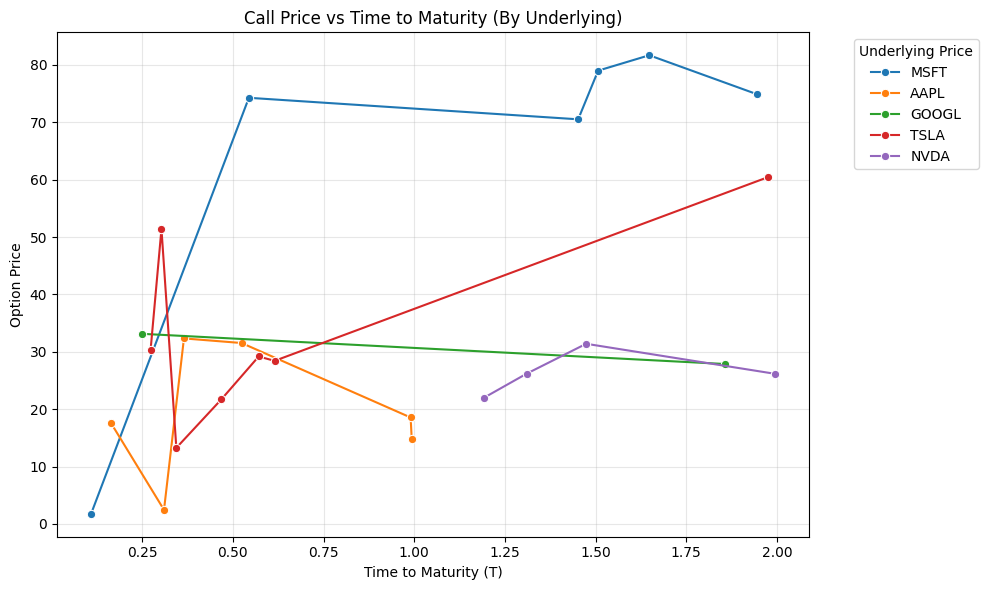

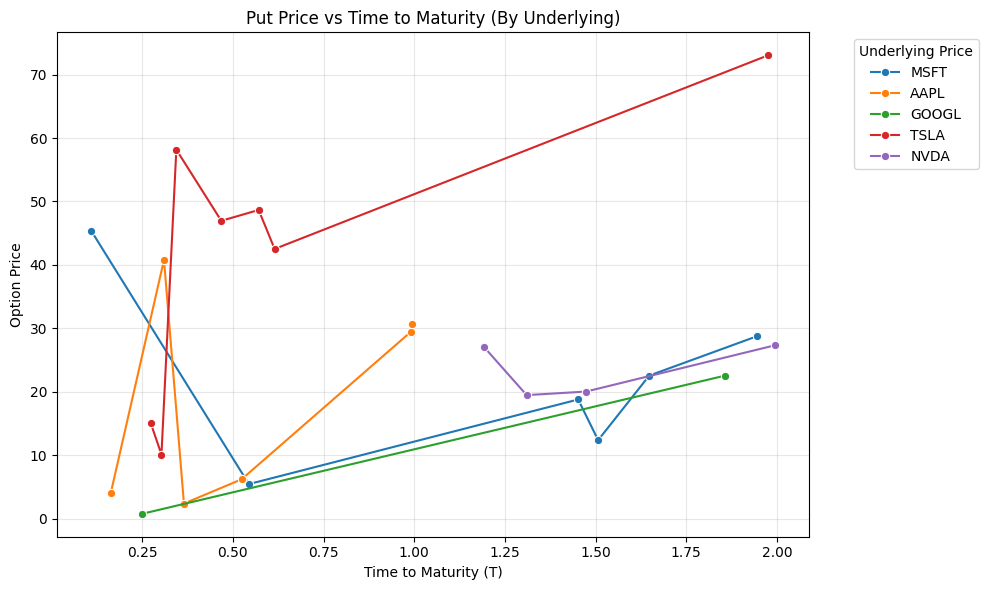

In [ ]:
df = df_pricing_sub.sort_values("T").dropna(subset=['price','T'])

for opt_type in ["call", "put"]:
    subset = df[df["option_type"] == opt_type]
    
    if subset.empty:
        continue
        
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=subset, x="T", y="price", hue="underlying", marker="o")
    
    plt.title(f"{opt_type.capitalize()} Price vs Time to Maturity (By Underlying)")
    plt.xlabel("Time to Maturity (T)")
    plt.ylabel("Option Price")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Underlying Price", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#### _generate_parity_summary

In [63]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [64]:
pricing_results_path = f"{output_dir}/analytics/analyzed_options.csv"
sensitivity_test_results_path = f"{output_dir}/analytics/sensitivity_test_results.csv"
stress_test_results_path = f"{output_dir}/analytics/stress_test_results.csv"
put_call_parity_path = f"{output_dir}/analytics/put_call_parity.csv"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
stress_test_results = pd.read_csv(stress_test_results_path)
put_call_parity = pd.read_csv(put_call_parity_path)

section_ordering = 1
asset = "Equity"
print(f">>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset}...")
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]
stress_test_results_sub = stress_test_results[stress_test_results["asset_class"] == asset]
put_call_parity_sub = put_call_parity[put_call_parity["asset_class_put"] == asset]

llm = get_llm()

>>>>>>>>> [Report Generator Agent] Compiling section 2.1: Equity...


In [70]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    prepare_parity_summary,
    create_parity_charts
)

df = put_call_parity_sub
section_ordering = "2.1"
section_level = 2

In [ ]:
df_str = df[["underlying", "is_parity_valid", "arbitrage_opportunity"]].to_csv(index=False)

In [72]:
system_prompt_text = (
    "You are an expert Quantitative Analyst writing a formal component for an Ongoing Performance Analysis (OPA) Report. "
    "Your output will be directly embedded into a professional document for senior management.\n\n"
    "### STRICT GUIDELINES:\n"
    "1. **Tone**: Use strictly professional, objective, and formal financial language. (e.g., Use 'The data indicates...' instead of 'I think...').\n"
    "2. **No Conversational Fillers**: Do NOT use phrases like 'Okay', 'Let's see', 'Let me check', 'Wait', or 'Here is the analysis'.\n"
    "3. **No Internal Monologue**: Do NOT output your thinking process. Only output the final analytical conclusions.\n"
    "4. **Direct Start**: Start directly with the bullet points or the section content.\n"
    "5. **Formatting**: Use standard Markdown (bolding for key metrics) suitable for a final report."
)
sys_msg = SystemMessage(content=system_prompt_text)

user_prompt = (
    f"Dataset for {asset}:\n{df_str}\n\n"
    "### TASK: Put Call Parity Check\n"
    "Please provide a structured analysis:\n"
    "STRICT GUIDELINES:\n"
    "- Start directly with the analysis. No introductory phrases.\n"
    "Group by the underlying, count the number of put/call pairs and how many of them pass the put-call parity test.\n"
    "If there are any put-call parity violations, show the arbitrage_opportunity.\n"
    "Output Format: Table with columns: underlying, put_call_pairs_count, fail_count, arbitrage_opportunity."
)

batch_inputs = [
    [sys_msg, HumanMessage(content=user_prompt)],
]
results = llm.batch(batch_inputs)
res_quality = results[0].content


full_report = (
    f"{"#"*(section_level+1)} {section_ordering}.2 Put/Call Parity Check\n{res_quality}\n\n"
)

In [73]:
_print_debug_summary(full_report)


[Paragraph 1]:
### 2.1.2 Put/Call Parity Check
| underlying | put_call_pairs_count | fail_count | arbitrage_opportunity |
|------------|----------------------|------------|-----------------------|
| **AAPL**   | 6                    | 0          |                       |
| **TSLA**   | 7                    | 0          |                       |
| **NVDA**   | 4                    | 0          |                       |
| **MSFT**   | 6                    | 0          |                       |
| **GOOGL**  | 2                    | 0          |                       |
----------------------------------------
[Paragraph 2]:
**Analysis Summary**:  
All put-call pairs across all underlying assets passed the put-call parity test (i.e., **fail_count = 0** for all groups). No arbitrage opportunities were identified in the dataset.
----------------------------------------



In [ ]:
img_reg, img_dev = create_parity_charts(df, asset)
display(Image(data=img_reg.getvalue()))

#### _generate_sensitivity_test_summary

##### aggregate_spot_sensitivity_data:

In [83]:
sensitivity_test_results_path = f"{output_dir}/analytics/sensitivity_test_results.csv"
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
asset = "Equity"
sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]

In [84]:
df = sensitivity_test_results_sub
scenario_type='spot'

In [87]:
prefix = f"sensitivity_scen_{scenario_type}_bump_"
all_bump_cols = [c for c in df.columns if prefix in c]
bump_zero_col = 'sensitivity_scen_spot_bump_0'
if bump_zero_col in df.columns:
    df['base_value'] = df[bump_zero_col]
    analysis_cols = [c for c in all_bump_cols if c != bump_zero_col]
else:
    df['base_value'] = df['price']
    analysis_cols = all_bump_cols

In [92]:
id_vars = ['underlying', 'delta', 'gamma', 'S', 'base_value']
df_long = df.melt(
    id_vars=id_vars, 
    value_vars=analysis_cols,
    var_name='scenario_name', 
    value_name='scenario_price'
)

df_long['spot_bump'] = df_long['scenario_name'].str.replace('sensitivity_scen_spot_bump_', '').astype(float)

df_long['dS'] = df_long['S'] * df_long['spot_bump']

df_long['real_pnl'] = df_long['scenario_price'] - df_long['base_value']

df_long['delta_pnl'] = df_long['delta'] * df_long['dS']

df_long['gamma_pnl'] = 0.5 * df_long['gamma'] * (df_long['dS']**2)

df_long['expect_pnl'] = df_long['delta_pnl'] + df_long['gamma_pnl']

df_long['residual_pnl'] = df_long['real_pnl'] - df_long['expect_pnl']

final_cols = ['underlying', 'spot_bump', 'real_pnl', 'delta_pnl', 'gamma_pnl', 'expect_pnl', 'residual_pnl']
df_long[final_cols]

,underlying,spot_bump,real_pnl,delta_pnl,gamma_pnl,expect_pnl,residual_pnl
0,AAPL,-0.05,-7.976142,-8.448560,0.437253,-8.011307,0.035164
1,AAPL,-0.05,3.008358,2.535940,0.437253,2.973193,0.035164
2,AAPL,-0.05,-4.826952,-5.242738,0.411416,-4.831322,0.004370
3,AAPL,-0.05,6.105048,5.689262,0.411416,6.100678,0.004370
4,TSLA,-0.05,-3.822765,-4.244053,0.426993,-3.817060,-0.005704
...,...,...,...,...,...,...,...
295,TSLA,0.05,-6.118704,-6.460881,0.348035,-6.112846,-0.005858
296,TSLA,0.05,5.633643,5.281328,0.356298,5.637626,-0.003983
297,TSLA,0.05,-6.263857,-6.616172,0.356298,-6.259874,-0.003983
298,AAPL,0.05,5.463817,4.974989,0.492664,5.467652,-0.003835


In [95]:
def aggregate_spot_sensitivity_data(df):
    prefix = f"sensitivity_scen_spot_bump_"
    all_bump_cols = [c for c in df.columns if prefix in c]
    bump_zero_col = f'sensitivity_scen_spot_bump_0'
    if bump_zero_col in df.columns:
        df['base_value'] = df[bump_zero_col]
        analysis_cols = [c for c in all_bump_cols if c != bump_zero_col]
    else:
        df['base_value'] = df['price']
        analysis_cols = all_bump_cols

    id_vars = ['underlying', 'delta', 'gamma', 'S', 'base_value']
    df_long = df.melt(
        id_vars=id_vars, 
        value_vars=analysis_cols,
        var_name='scenario_name', 
        value_name='scenario_price'
    )
    df_long['spot_bump'] = df_long['scenario_name'].str.replace(f'sensitivity_scen_spot_bump_', '').astype(float)
    df_long['dS'] = df_long['S'] * df_long['spot_bump']
    df_long['real_pnl'] = df_long['scenario_price'] - df_long['base_value']
    df_long['delta_pnl'] = df_long['delta'] * df_long['dS']
    df_long['gamma_pnl'] = 0.5 * df_long['gamma'] * (df_long['dS']**2)
    df_long['expect_pnl'] = df_long['delta_pnl'] + df_long['gamma_pnl']
    df_long['residual_pnl'] = df_long['real_pnl'] - df_long['expect_pnl']
    final_cols = ['underlying', f'{scenario_type}_bump', 'real_pnl', 'delta_pnl', 'gamma_pnl', 'expect_pnl', 'residual_pnl']
    return df_long[final_cols]
aggregate_sensitivity_data(df)

,underlying,spot_bump,real_pnl,delta_pnl,gamma_pnl,expect_pnl,residual_pnl
0,AAPL,-0.05,-7.976142,-8.448560,0.437253,-8.011307,0.035164
1,AAPL,-0.05,3.008358,2.535940,0.437253,2.973193,0.035164
2,AAPL,-0.05,-4.826952,-5.242738,0.411416,-4.831322,0.004370
3,AAPL,-0.05,6.105048,5.689262,0.411416,6.100678,0.004370
4,TSLA,-0.05,-3.822765,-4.244053,0.426993,-3.817060,-0.005704
...,...,...,...,...,...,...,...
295,TSLA,0.05,-6.118704,-6.460881,0.348035,-6.112846,-0.005858
296,TSLA,0.05,5.633643,5.281328,0.356298,5.637626,-0.003983
297,TSLA,0.05,-6.263857,-6.616172,0.356298,-6.259874,-0.003983
298,AAPL,0.05,5.463817,4.974989,0.492664,5.467652,-0.003835


##### create_spot_sensitivity_chart

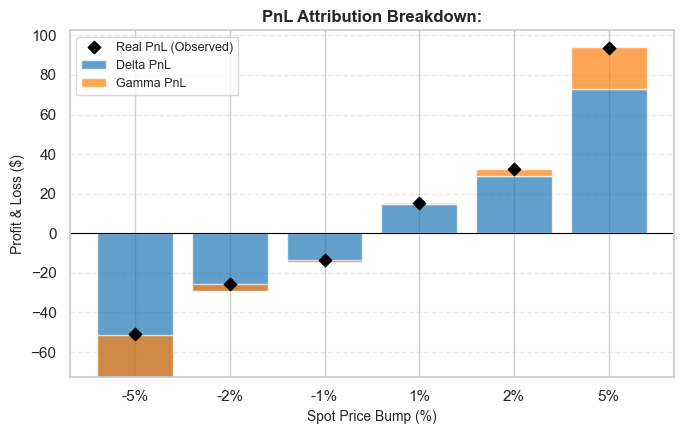

In [97]:
df_agg = df_long.groupby(['spot_bump'])[[
    'real_pnl', 
    'delta_pnl', 
    'gamma_pnl', 
    'expect_pnl'
]].sum().reset_index()

df_plot = df_agg.sort_values('spot_bump')

bumps = [f"{int(b*100)}%" for b in df_plot['spot_bump']]
delta_pnl = df_plot['delta_pnl']
gamma_pnl = df_plot['gamma_pnl']
real_pnl = df_plot['real_pnl']

plt.figure(figsize=(7, 4.5))

p1 = plt.bar(bumps, delta_pnl, color='#1f77b4', alpha=0.7, label='Delta PnL')
p2 = plt.bar(bumps, gamma_pnl, bottom=delta_pnl, color='#ff7f0e', alpha=0.7, label='Gamma PnL')

plt.scatter(bumps, real_pnl, color='black', marker='D', s=40, zorder=3, label='Real PnL (Observed)')

plt.axhline(0, color='black', linewidth=0.8, linestyle='-')

plt.title(f"PnL Attribution Breakdown:", fontsize=12, weight='bold')
plt.xlabel("Spot Price Bump (%)", fontsize=10)
plt.ylabel("Profit & Loss ($)", fontsize=10)
plt.legend(loc='best', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()

##### aggregate_vol_sensitivity_data

In [102]:
prefix = f"sensitivity_scen_vol_bump_"
all_bump_cols = [c for c in df.columns if prefix in c]
bump_zero_col = f'sensitivity_scen_vol_bump_0'
if bump_zero_col in df.columns:
    df['base_value'] = df[bump_zero_col]
    analysis_cols = [c for c in all_bump_cols if c != bump_zero_col]
else:
    df['base_value'] = df['price']
    analysis_cols = all_bump_cols
id_vars = ['underlying', 'base_value']
df_long = df.melt(
    id_vars=id_vars, 
    value_vars=analysis_cols,
    var_name='scenario_name', 
    value_name='scenario_price'
)
df_long['vol_bump'] = df_long['scenario_name'].str.replace(f'sensitivity_scen_vol_bump_', '').astype(float)
df_long['real_pnl'] = df_long['scenario_price'] - df_long['base_value']
final_cols = ['underlying', 'vol_bump', 'real_pnl']
df_agg = df_long.groupby(['vol_bump'])[[
    'real_pnl', 
]].sum().reset_index()

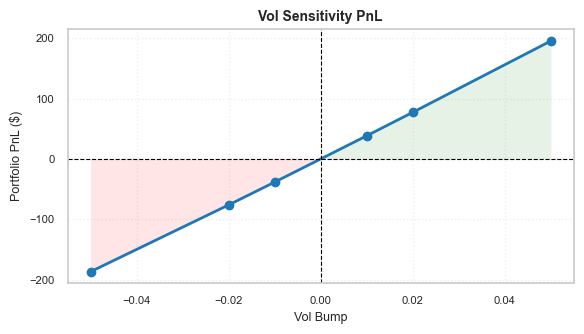

In [104]:
plt.figure(figsize=(6, 3.5)) # Compact size for Word doc

plt.plot(df_agg['vol_bump'], df_agg['real_pnl'], marker='o', linewidth=2, color='#1f77b4', label='PnL')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.fill_between(df_agg['vol_bump'], df_agg['real_pnl'], 0, where=(df_agg['real_pnl']>=0), 
                    facecolor='green', alpha=0.1, interpolate=True)
plt.fill_between(df_agg['vol_bump'], df_agg['real_pnl'], 0, where=(df_agg['real_pnl']<0), 
                    facecolor='red', alpha=0.1, interpolate=True)
scenario_label = 'Vol'
plt.title(f"{scenario_label} Sensitivity PnL", fontsize=10, weight='bold')
plt.xlabel(f"{scenario_label} Bump", fontsize=9)
plt.ylabel("Portfolio PnL ($)", fontsize=9)
plt.grid(True, alpha=0.3, linestyle=':')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

In [103]:
df_agg

,vol_bump,real_pnl
0,-0.05,-186.505658
1,-0.02,-75.978976
2,-0.01,-38.186412
3,0.01,38.539569
4,0.02,77.396046
5,0.05,195.559719


In [ ]:

    
# Plot Line


# Reference Lines


# Color zones (Green for profit, Red for loss)

# Styling
scenario_label = scenario_type.capitalize()
if scenario_type == 'vol': scenario_label = "Volatility"



##### _generate_sensitivity_test_summary

In [105]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [106]:
pricing_results_path = f"{output_dir}/analytics/analyzed_options.csv"
sensitivity_test_results_path = f"{output_dir}/analytics/sensitivity_test_results.csv"
stress_test_results_path = f"{output_dir}/analytics/stress_test_results.csv"
put_call_parity_path = f"{output_dir}/analytics/put_call_parity.csv"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
stress_test_results = pd.read_csv(stress_test_results_path)
put_call_parity = pd.read_csv(put_call_parity_path)

section_ordering = 1
asset = "Equity"
print(f">>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset}...")
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]
stress_test_results_sub = stress_test_results[stress_test_results["asset_class"] == asset]
put_call_parity_sub = put_call_parity[put_call_parity["asset_class_put"] == asset]

llm = get_llm()

>>>>>>>>> [Report Generator Agent] Compiling section 2.1: Equity...


In [107]:
section_ordering = "2.2"
asset = "Equity"
section_level = 2
print(f">>>>>>>>> [Report Generator Agent] Compiling section {section_ordering}: {asset}...")
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]
stress_test_results_sub = stress_test_results[stress_test_results["asset_class"] == asset]
put_call_parity_sub = put_call_parity[put_call_parity["asset_class_put"] == asset]

>>>>>>>>> [Report Generator Agent] Compiling section 2.2: Equity...


In [108]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    aggregate_spot_sensitivity_data,
    create_spot_sensitivity_chart,
    aggregate_vol_sensitivity_data,
    create_vol_sensitivity_chart
)

df = sensitivity_test_results_sub

In [111]:
df_spot = aggregate_spot_sensitivity_data(df)
df_vol = aggregate_vol_sensitivity_data(df)

spot_str = df_spot.to_markdown(index=False) if df_spot is not None else "No Data"
vol_str = df_vol.to_markdown(index=False) if df_vol is not None else "No Data"


In [114]:
df_vol

,vol_bump,real_pnl
0,-0.05,-186.505658
1,-0.02,-75.978976
2,-0.01,-38.186412
3,0.01,38.539569
4,0.02,77.396046
5,0.05,195.559719


In [115]:
system_prompt_text = (
    "You are an expert Quantitative Analyst writing a formal component for an Ongoing Performance Analysis (OPA) Report. "
    "Your output will be directly embedded into a professional document for senior management.\n\n"
    "You are analyzing sensitivity test results."
    "### STRICT GUIDELINES:\n"
    "1. **Tone**: Use strictly professional, objective, and formal financial language. (e.g., Use 'The data indicates...' instead of 'I think...').\n"
    "2. **No Conversational Fillers**: Do NOT use phrases like 'Okay', 'Let's see', 'Let me check', 'Wait', or 'Here is the analysis'.\n"
    "3. **No Internal Monologue**: Do NOT output your thinking process. Only output the final analytical conclusions.\n"
    "4. **Direct Start**: Start directly with the bullet points or the section content.\n"
    "5. **Formatting**: Use standard Markdown (bolding for key metrics) suitable for a final report."
)
sys_msg = SystemMessage(content=system_prompt_text)

prompts = [
    # Spot / Gamma
    f"Portfolio Spot Sensitivity for {asset}:\n{spot_str}\n\n"
    "### Task: Spot & Gamma Analysis\n"
    "1. **Directional Bias**: Does the Delta explain the majority of portfolio gain on Up or Down moves?\n"
    "2. **Convexity**: Is the PnL curve convex (Long Gamma) or concave (Short Gamma)? Check if losses accelerate in one direction.\n",
    
    # Vol / Vega
    f"Portfolio Volatility Sensitivity for {asset}:\n{vol_str}\n\n"
    "### Task: Volatility Analysis\n"
    "1. is the relationship between the pnl and vol bump linear?",
    
    # # Rate / Rho
    # f"Portfolio Rate Sensitivity for {asset}:\n{rate_str}\n\n"
    # "### Task: Interest Rate Analysis\n"
    # "1. **Rho Exposure**: How does the portfolio react to rate hikes?\n"
    # "2. **Implication**: Briefly explain what this implies about the positioning (e.g., Net Long/Short)."
]

inputs = [[sys_msg, HumanMessage(content=p)] for p in prompts]
results = llm.batch(inputs)

In [119]:
res_spot = results[0].content
res_vol = results[1].content

report_spot = f"{"#"*(section_level+1)} {section_ordering}.1 Spot & Gamma Analysis\n{res_spot}\n\n"

In [120]:
_print_debug_summary(report_spot)


[Paragraph 1]:
### 2.2.1 Spot & Gamma Analysis
**Spot & Gamma Analysis**
----------------------------------------
[Paragraph 2]:
1. **Directional Bias**:  
   The portfolio exhibits a **neutral directional bias**, as Delta does not dominate the PnL across up or down moves. For both positive and negative spot bumps, the **Delta PnL aligns closely with the Real PnL** (e.g., at ±0.01, Delta explains ~96% of Real PnL). However, the consistent **positive Gamma PnL** (e.g., +0.857 at ±0.01) indicates convexity adjustments offset directional exposure, neutralizing asymmetry in gains/losses.
----------------------------------------
[Paragraph 3]:
2. **Convexity**:  
   The PnL curve is **convex (Long Gamma)**. Gamma PnL is **positive for both up and down moves**, confirming the portfolio benefits from volatility in either direction. For example:  
   - At a **+0.05 bump**, Gamma contributes **+21.43** to Real PnL (35% of total gain).  
   - At a **-0.05 bump**, Gamma reduces losses by **+21.4

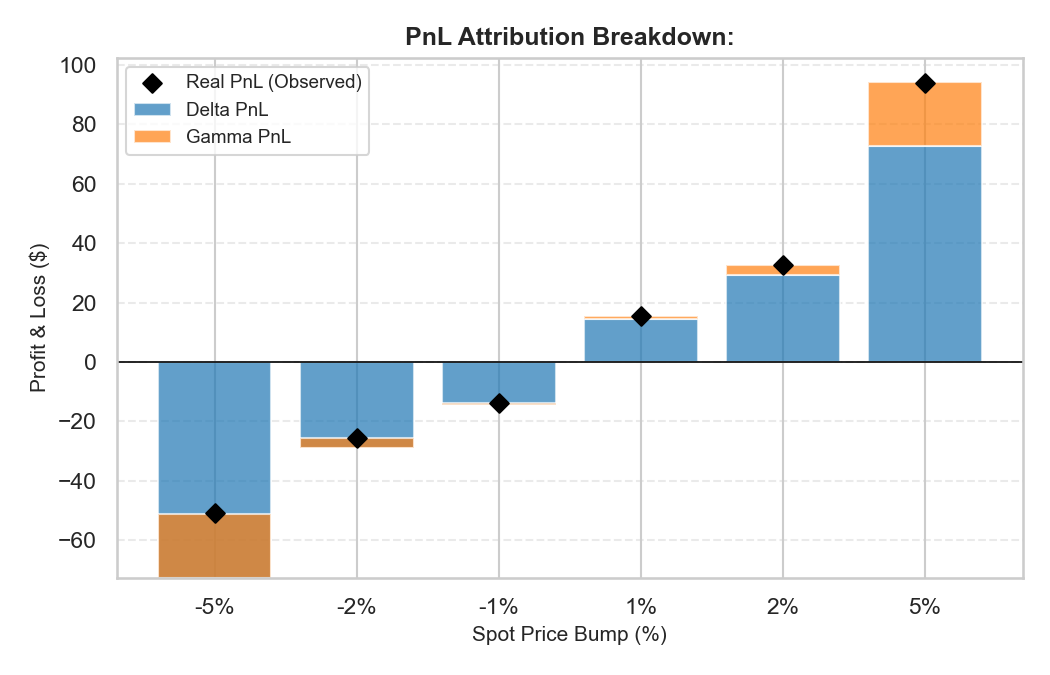

In [123]:
img_spot = create_spot_sensitivity_chart(df_spot)
display(Image(data=img_spot.getvalue()))

NameError: name 'io' is not defined

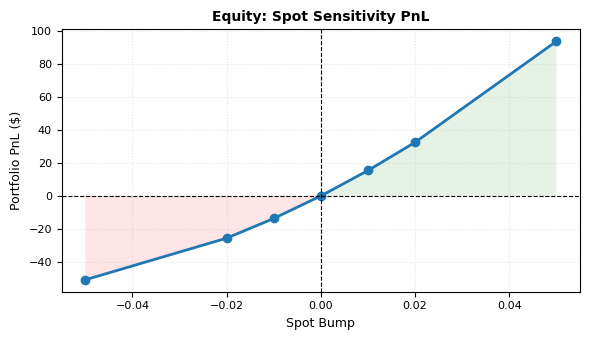

In [67]:
img_spot = create_sensitivity_chart(df_spot, 'spot', asset)
display(Image(data=img_spot.getvalue()))

In [68]:
cols_to_show = ['Bump', 'Net_PnL_Disp', 'Portfolio_Value_Disp']
spot_str = df_spot[cols_to_show].to_markdown(index=False) if df_spot is not None else "No Data"
vol_str = df_vol[cols_to_show].to_markdown(index=False) if df_vol is not None else "No Data"
rate_str = df_rate[cols_to_show].to_markdown(index=False) if df_rate is not None else "No Data"

sys_msg = SystemMessage(content=(
    "You are a Senior Risk Manager analyzing Portfolio Stress Tests. "
    "Analyze the aggregated PnL data provided. Be concise, professional, and focus on risk exposures."
))

# Define the 3 prompts
prompts = [
    # Spot / Gamma
    f"Portfolio Spot Sensitivity for {asset}:\n{spot_str}\n\n"
    "### Task: Spot & Gamma Analysis\n"
    "1. **Directional Bias**: Does the portfolio gain on Up or Down moves? (Delta view)\n"
    "2. **Convexity**: Is the PnL curve convex (Long Gamma) or concave (Short Gamma)? Check if losses accelerate in one direction.\n"
    "3. **Tail Risk**: Comment on the worst-case loss in the table.",
    
    # Vol / Vega
    f"Portfolio Volatility Sensitivity for {asset}:\n{vol_str}\n\n"
    "### Task: Volatility Analysis\n"
    "1. **Vega Exposure**: Is the portfolio Long Vega (gains when vol rises) or Short Vega?\n"
    "2. **Impact**: Is the PnL impact significant compared to the spot movements?",
    
    # Rate / Rho
    f"Portfolio Rate Sensitivity for {asset}:\n{rate_str}\n\n"
    "### Task: Interest Rate Analysis\n"
    "1. **Rho Exposure**: How does the portfolio react to rate hikes?\n"
    "2. **Implication**: Briefly explain what this implies about the positioning (e.g., Net Long/Short)."
]

# Run LLM (Batch)
print("  - Invoking LLM batch analysis...")
inputs = [[sys_msg, HumanMessage(content=p)] for p in prompts]

  - Invoking LLM batch analysis...


In [69]:
results = llm.batch(inputs)

In [70]:
res_spot = results[0].content
res_vol = results[1].content
res_rate = results[2].content

In [71]:
_print_debug_summary(res_spot)


[Paragraph 1]:
**1. Directional Bias**:  
The portfolio gains on **up moves** (positive bumps) and incurs losses on **down moves** (negative bumps). This indicates a **long Delta** exposure, with directional bias favoring upward equity price movements.
----------------------------------------
[Paragraph 2]:
**2. Convexity**:  
The PnL curve exhibits **convexity (long Gamma)**. Losses accelerate with larger down moves (e.g., -0.05 bump results in a -50.91 loss vs. -25.65 at -0.02). Similarly, gains increase with upward moves (e.g., +0.05 bump yields +93.8 vs. +15.41 at +0.01). This confirms **positive convexity**, implying the portfolio benefits from volatility.
----------------------------------------
[Paragraph 3]:
**3. Tail Risk**:  
The **worst-case loss** is **-50.91** (5.8% of portfolio value) under a **-5% spot decline**. This represents a significant tail risk exposure, as losses escalate non-linearly with severe down moves. Monitoring stress scenarios beyond the table (e.g., -

#### _generate_stress_test_summary

In [7]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [8]:
pricing_results_path = f"{output_dir}/analytics/analyzed_options.csv"
sensitivity_test_results_path = f"{output_dir}/analytics/sensitivity_test_results.csv"
stress_test_results_path = f"{output_dir}/analytics/stress_test_results.csv"
put_call_parity_path = f"{output_dir}/analytics/put_call_parity.csv"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
stress_test_results = pd.read_csv(stress_test_results_path)
put_call_parity = pd.read_csv(put_call_parity_path)


llm = get_llm()

In [9]:
section_ordering = 1
asset = "Equity"
print(f">>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset}...")
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]
stress_test_results_sub = stress_test_results[stress_test_results["asset_class"] == asset]
put_call_parity_sub = put_call_parity[put_call_parity["asset_class_put"] == asset]

>>>>>>>>> [Report Generator Agent] Compiling section 2.1: Equity...


In [10]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    prepare_stress_test_data,
    create_stress_chart
)

df = stress_test_results_sub


In [11]:
df_agg_underlying_level, df_agg_scenario_level = prepare_stress_test_data(df)
df_str = df_agg_scenario_level.to_markdown(index=False)

In [13]:
system_prompt_text = (
    "You are an expert Quantitative Analyst writing a formal component for an Ongoing Performance Analysis (OPA) Report. "
    "Your output will be directly embedded into a professional document for senior management.\n\n"
    "You are analyzing stress test results."
    "### STRICT GUIDELINES:\n"
    "1. **Tone**: Use strictly professional, objective, and formal financial language. (e.g., Use 'The data indicates...' instead of 'I think...').\n"
    "2. **No Conversational Fillers**: Do NOT use phrases like 'Okay', 'Let's see', 'Let me check', 'Wait', or 'Here is the analysis'.\n"
    "3. **No Internal Monologue**: Do NOT output your thinking process. Only output the final analytical conclusions.\n"
    "4. **Direct Start**: Start directly with the bullet points or the section content.\n"
    "5. **Formatting**: Use standard Markdown (bolding for key metrics) suitable for a final report."
)
sys_msg = SystemMessage(content=system_prompt_text)

user_prompt = (
    f"Stress Test Results for {asset}:\n\n"
    f"{df_str}\n\n"
    "Please provide a Risk Assessment covering:\n"
    "1. Rank the severity of stress scenario and provide the potential reason."
)
batch_inputs = [
    [sys_msg, HumanMessage(content=user_prompt)],
]
results = llm.batch(batch_inputs)

In [14]:
res_quality = results[0].content

In [15]:
_print_debug_summary(res_quality)


[Paragraph 1]:
**Risk Assessment: Stress Scenario Severity Ranking**
----------------------------------------
[Paragraph 2]:
The severity of stress scenarios is ranked based on the magnitude of potential losses (PnL %) under adverse conditions. The analysis is as follows:
----------------------------------------
[Paragraph 3]:
1. **Volatility Collapse (-176.52% PnL)**  
   - **Severity**: Most severe negative impact.  
   - **Reason**: A sharp decline in volatility (e.g., unwind of hedging positions or liquidity dry-up) could trigger significant losses, particularly in portfolios with long volatility exposure or leveraged positions.
----------------------------------------
[Paragraph 4]:
2. **Liquidation Scenario (447.64% PnL)**  
   - **Severity**: Highest positive PnL, indicating an unexpected gain.  
   - **Reason**: This scenario likely reflects forced liquidation dynamics (e.g., margin calls or portfolio rebalancing), which may paradoxically benefit certain strategies (e.g., shor

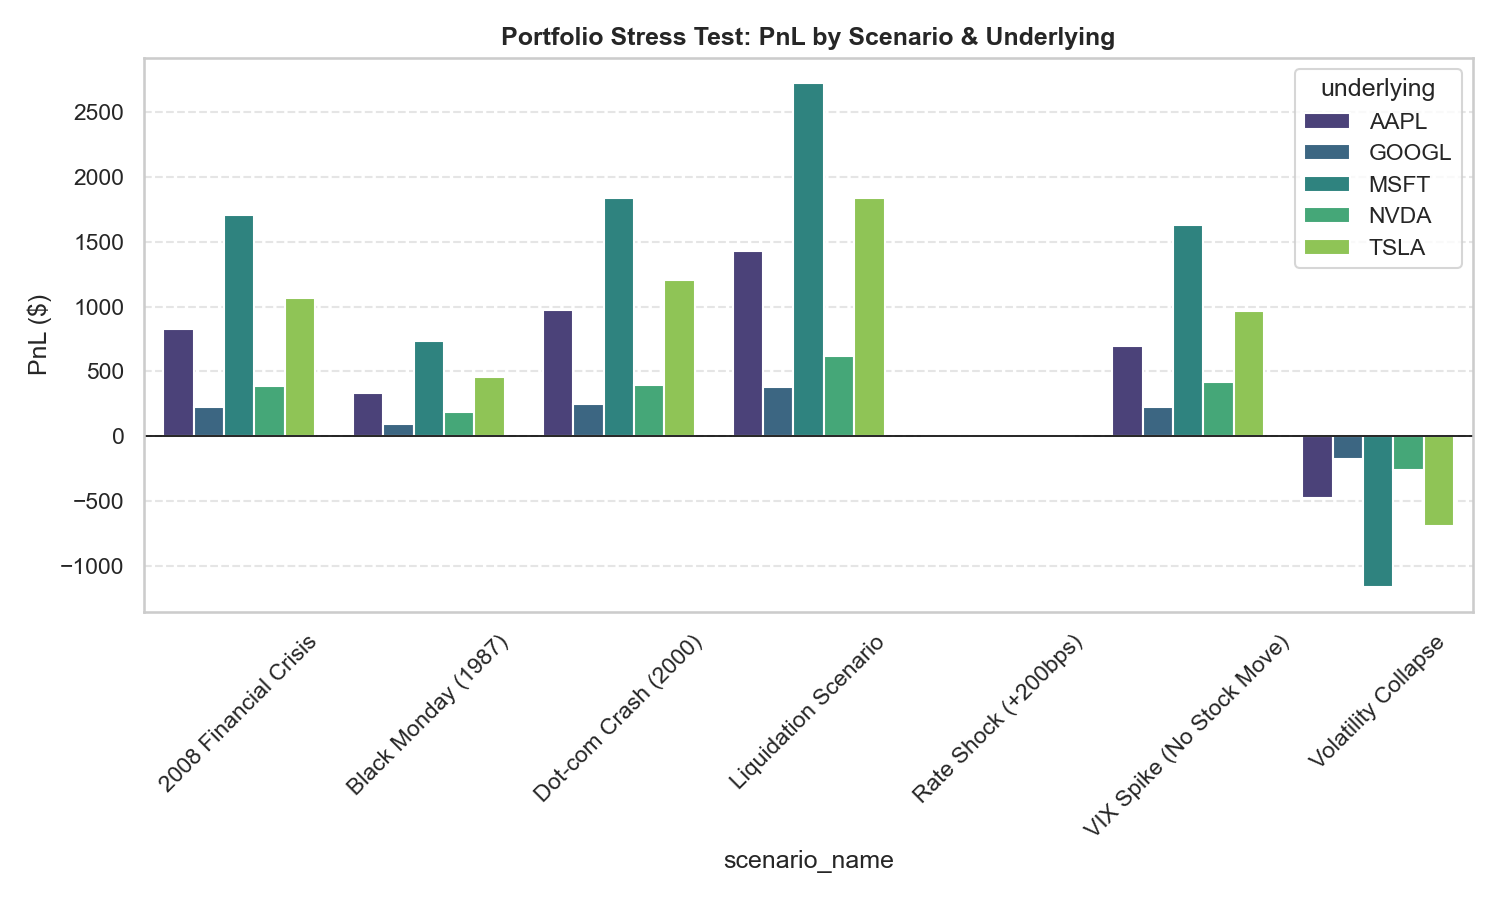

In [171]:
img_stress = create_stress_chart(df_agg_underlying_level)
display(Image(data=img_stress.getvalue()))

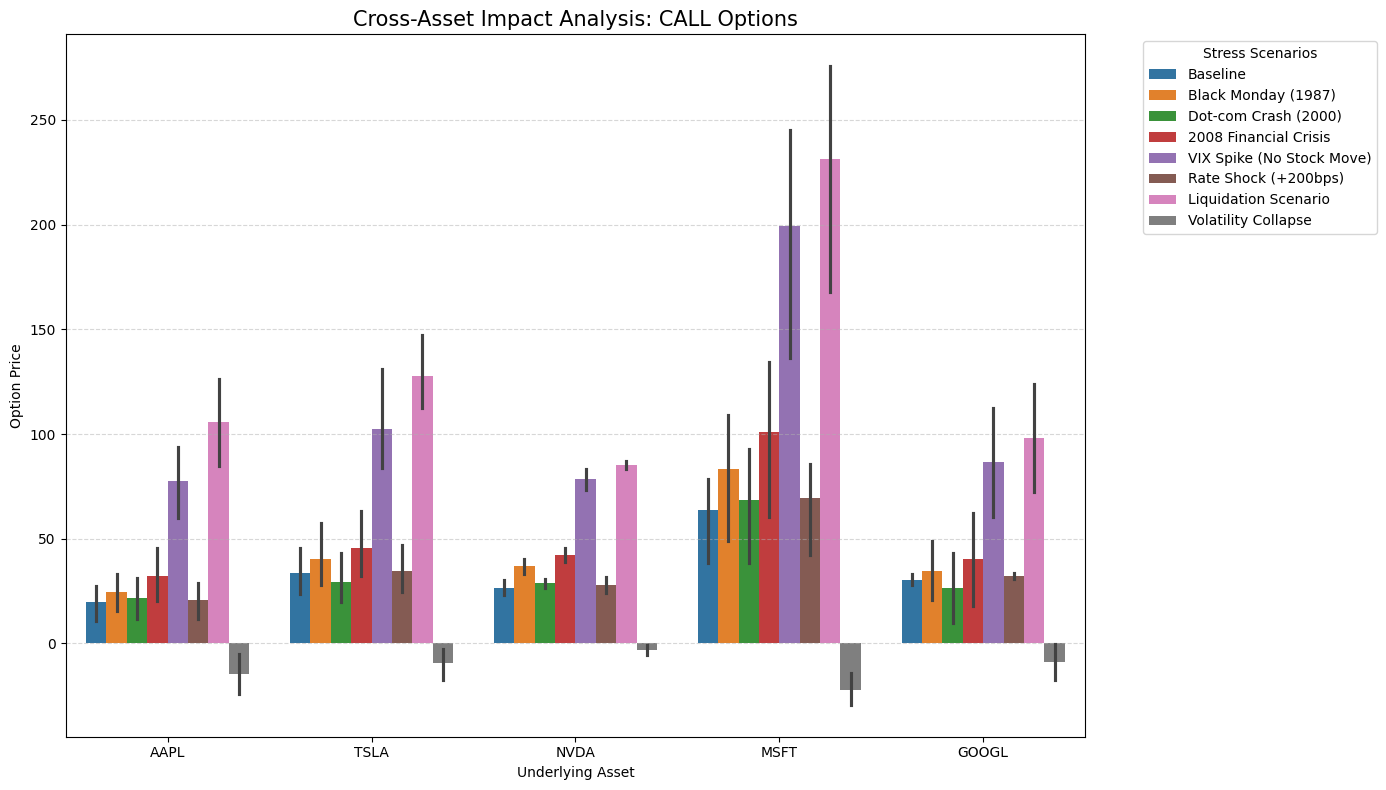

In [88]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_plot, 
    x='Underlying', 
    y='Price', 
    hue='Scenario',
    palette='tab10'
)

plt.title(f"Cross-Asset Impact Analysis: {opt_type.upper()} Options", fontsize=15)
plt.ylabel("Option Price")
plt.xlabel("Underlying Asset")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title="Stress Scenarios", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

##### prepare_stress_test_data

In [135]:
stress_test_results_path = f"{output_dir}/analytics/stress_test_results.csv"
stress_test_results = pd.read_csv(stress_test_results_path)
asset = "Equity"
stress_test_results_sub = stress_test_results[stress_test_results["asset_class"] == asset]

In [136]:
df = stress_test_results_sub

In [137]:
prefix = "stress_scen_"
cols = [c for c in df.columns if prefix in c]

In [142]:
id_vars = ['underlying','price']
df_long = df.melt(
    id_vars=id_vars, 
    value_vars=cols,
    var_name='scenario_name', 
    value_name='scenario_price'
)
df_long['scenario_name'] = df_long['scenario_name'].str.replace(f'stress_scen_', '')
df_long['PnL'] = df_long['scenario_price'] - df_long['price']

In [ ]:
df_long

,underlying,price,scenario_name,scenario_price,PnL
0,AAPL,31.526104,Black Monday (1987),31.487579,-0.038525
1,AAPL,6.218109,Black Monday (1987),50.627533,44.409424
2,AAPL,18.543290,Black Monday (1987),36.031024,17.487733
3,AAPL,29.426828,Black Monday (1987),91.781520,62.354692
4,TSLA,13.250524,Black Monday (1987),20.651462,7.400938
...,...,...,...,...,...
345,TSLA,48.662930,Volatility Collapse,-0.047199,-48.710129
346,TSLA,21.693682,Volatility Collapse,-13.360565,-35.054246
347,TSLA,46.951739,Volatility Collapse,-0.000008,-46.951746
348,AAPL,14.844934,Volatility Collapse,-28.304960,-43.149894


In [150]:
df_agg = df_long.groupby(['underlying','scenario_name'])[[
    'price',
    'PnL', 
]].sum().reset_index()
df_agg['PnL %'] = (df_agg['PnL'] / df_agg['price']*100).round(2).astype(str) + "%"
df_agg

,underlying,scenario_name,price,PnL,PnL %
0,AAPL,2008 Financial Crisis,230.902639,829.345346,359.18%
1,AAPL,Black Monday (1987),230.902639,332.308519,143.92%
2,AAPL,Dot-com Crash (2000),230.902639,972.130876,421.01%
3,AAPL,Liquidation Scenario,230.902639,1427.060210,618.04%
4,AAPL,Rate Shock (+200bps),230.902639,-1.460323,-0.63%
5,AAPL,VIX Spike (No Stock Move),230.902639,693.903899,300.52%
6,AAPL,Volatility Collapse,230.902639,-474.367043,-205.44%
7,GOOGL,2008 Financial Crisis,84.330611,227.343208,269.59%
8,GOOGL,Black Monday (1987),84.330611,92.772591,110.01%
9,GOOGL,Dot-com Crash (2000),84.330611,250.113854,296.59%


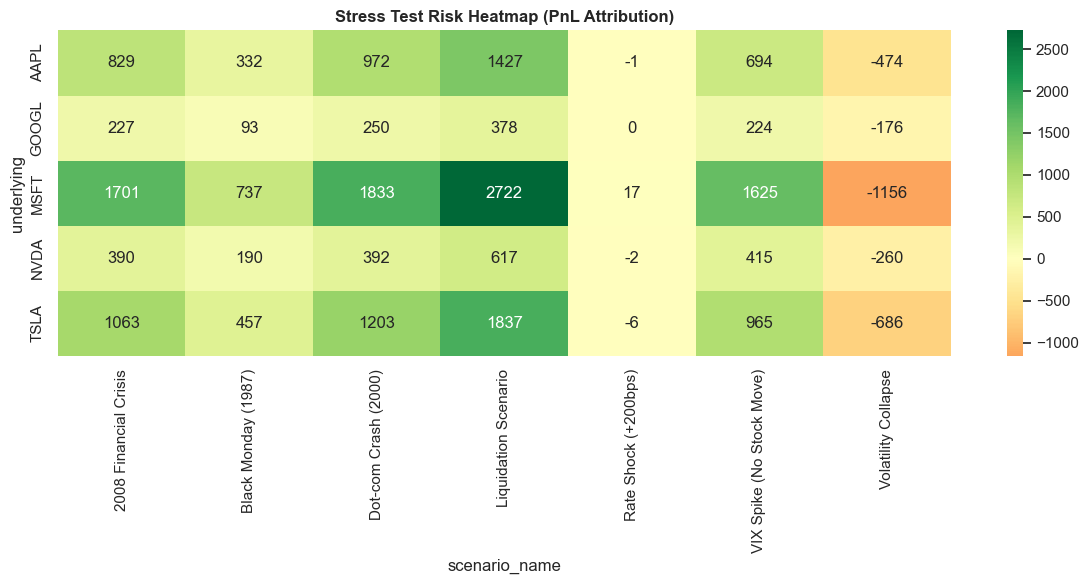

In [ ]:
pivot_df = df_agg.pivot(index='underlying', columns='scenario_name', values='PnL')
    
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap='RdYlGn', center=0)

plt.title("Stress Test Risk Heatmap (PnL Attribution)", weight='bold')
plt.tight_layout()

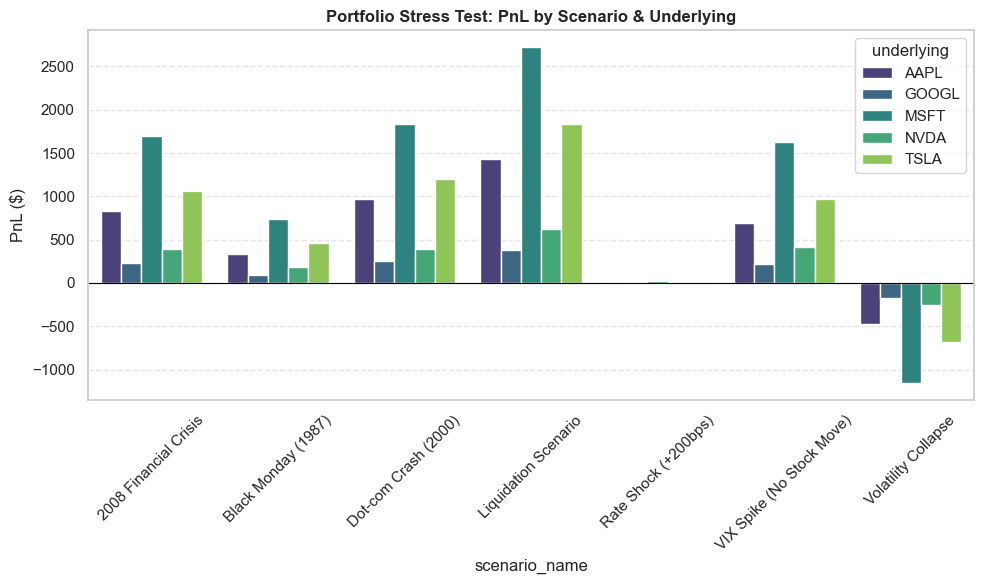

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_agg, x='scenario_name', y='PnL', hue='underlying', palette='viridis')

plt.axhline(0, color='black', linewidth=0.8) 
plt.title("Portfolio Stress Test: PnL by Scenario & Underlying", weight='bold')
plt.xticks(rotation=45)
plt.ylabel("PnL ($)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(7, 4))
colors = ['#d62728' if x < 0 else '#2ca02c' for x in df_stress['Portfolio_PnL']]
bars = plt.barh(df_stress['Scenario'], df_stress['Portfolio_PnL'], color=colors, alpha=0.8)
    

#### _generate_parity_summary

In [ ]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [ ]:
pricing_results_path = f"{output_dir}/analytics/analyzed_options.csv"
sensitivity_test_results_path = f"{output_dir}/analytics/sensitivity_test_results.csv"
stress_test_results_path = f"{output_dir}/analytics/stress_test_results.csv"
put_call_parity_path = f"{output_dir}/analytics/put_call_parity.csv"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
stress_test_results = pd.read_csv(stress_test_results_path)
put_call_parity = pd.read_csv(put_call_parity_path)

section_ordering = 1
asset = "Equity"
print(f">>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset}...")
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]
stress_test_results_sub = stress_test_results[stress_test_results["asset_class"] == asset]
put_call_parity_sub = put_call_parity[put_call_parity["asset_class_put"] == asset]

llm = get_llm()

In [102]:
from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    prepare_parity_summary,
    create_parity_charts
)

df = put_call_parity_sub


In [104]:
_, summary_md = prepare_parity_summary(df)

In [105]:
system_prompt = (
    "You are an Arbitrage Trader and Quantitative Researcher. "
    "Your task is to validate the 'Put-Call Parity' relationship for an options portfolio. "
    "Identify if deviations are noise or actionable arbitrage opportunities.\n\n"
    "FORMATTING RULES:\n"
    "1. Do NOT use document titles, dates, or signatures.\n"
    "2. Start directly with the analysis headers.\n"
    "3. Be concise and data-driven."
)

user_prompt = (
    f"Put-Call Parity Analysis for {asset}:\n\n"
    f"{summary_md}\n\n"
    "Please provide a structured analysis:\n"
    "1. **Model Consistency**: Is the pass rate acceptable? If low, what does it imply about the data quality or market efficiency?\n"
    "2. **Arbitrage Assessment**: Look at the 'Top 5 Violations'. Are the 'abs_diff' values large enough to cover transaction costs, or are they negligible?\n"
    "3. **Strike Bias**: (Hypothetically) Does the violation usually occur at deep ITM/OTM strikes due to liquidity issues?\n"
    "4. **Recommendation**: Should we flag these data points for cleaning, or execute arbitrage trades?"
)

ai_msg = llm.invoke([
    SystemMessage(content=system_prompt),
    HumanMessage(content=user_prompt)
])

In [106]:
_print_debug_summary(ai_msg.content)


[Paragraph 1]:
### Model Consistency  
The 100.00% pass rate and zero mean/max deviation indicate perfect adherence to put-call parity across all 25 pairs. This suggests either:  
- **Market efficiency** (no mispricing), or  
- **Data quality issues** (e.g., missing parameters like risk-free rates, dividends, or incorrect pricing).  
However, the absence of deviations implies no actionable arbitrage opportunities.
----------------------------------------
[Paragraph 2]:
---
----------------------------------------
[Paragraph 3]:
### Arbitrage Assessment  
The "Top 5 Violations" show **abs_diff = 0.0000**, which is inconsistent with the term "violations." If deviations were non-zero but truncated or misrepresented, further analysis would be needed. As currently presented, **no arbitrage opportunities exist** due to zero deviations. Transaction costs would render any non-zero deviations unprofitable.
----------------------------------------
[Paragraph 4]:
---
----------------------------

In [107]:
img_reg, img_dev = create_parity_charts(df, asset)

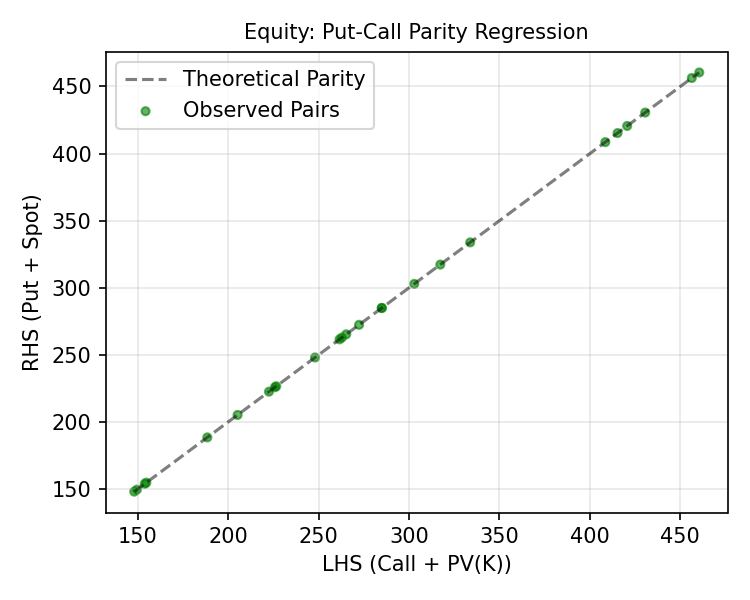

In [108]:
display(Image(data=img_reg.getvalue()))

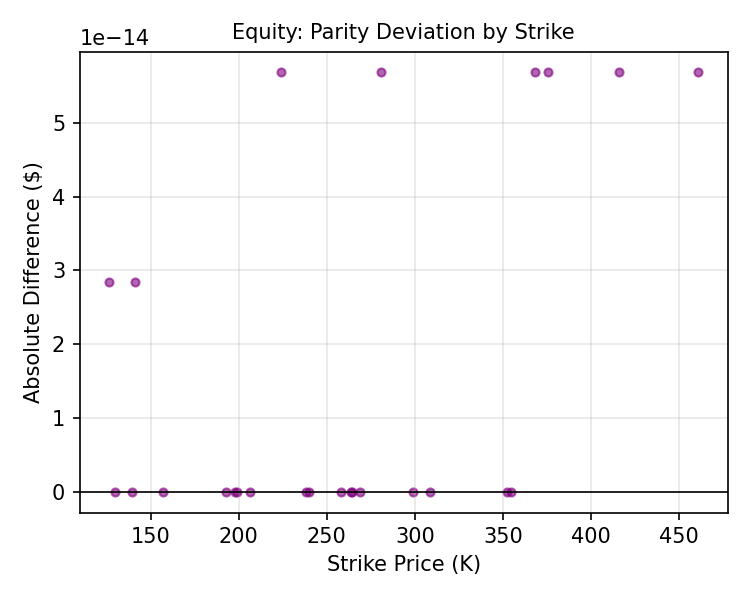

In [109]:
display(Image(data=img_dev.getvalue()))

### Node Level

In [117]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

from bsm_multi_agents.agents import pricing_validator_node
importlib.reload(pricing_validator_node)
from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
    pricing_validator_tool_node,
)

from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    report_generator_agent_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)
state = pricing_validator_agent_node(state)
state = pricing_validator_tool_node(state)
state = pricing_validator_agent_node(state)
state = report_generator_agent_node(state)
state


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Completed task, moving to next stage

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: ['verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis']

>>> [Pricing Validator Tool] Executing validation calls...
>>> [Pricing Validator Tool] Executing tool calls: verify_put_call_parity
>>> [Pricing Validator Tool] Executing tool calls: run_sensitivity_analysis
>>> [Pricing Validator Tool] Executing tool calls: run_stress_analysis

>>> [Pricing Validator Agent] Starting validation planning...

>>> [Report Generator Agent] Compiling final report...
>>>>>> [Report Ge

{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='The input CSV for validation is located at: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv\n\nPlease run the following validation suite now:\n- verify_put_call_parity\n- run_sensitivity_analysis\n- run_stress_analysisdo not set scenarios argument if not specified', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwe

# Graph

In [8]:
from langgraph.graph import StateGraph, END, START

from bsm_multi_agents.graph.state import WorkflowState
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
    pricing_validator_tool_node,
)

from bsm_multi_agents.agents.report_generator_node import (
    report_generator_agent_node,
)


In [9]:
def should_continue_for_pricing_calculator(state):
    messages = state["messages"]
    if not messages:
        return END
        
    last_msg = messages[-1]
    
    # 1. If it's an Agent message (AIMessage) with tool_calls -> Go to Tool
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "pricing_calculator_tool"
    
    # 2. If it's a Tool Execution message (ToolMessage)
    #    Check for errors to decide if we should retry
    if isinstance(last_msg, ToolMessage):
         if last_msg.content.startswith("Error"):
             # OPTIONAL: Check iteration count to prevent infinite loop
             return "pricing_calculator_agent"
         
         # Success -> Finish
         return "pricing_validator_agent"
    
    # Default
    return "pricing_validator_agent"

def should_continue_for_pricing_validator(state):
    messages = state["messages"]
    if not messages:
        return END
        
    last_msg = messages[-1]
    
    # 1. If it's an Agent message (AIMessage) with tool_calls -> Go to Tool
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "pricing_validator_tool"
    
    # 2. If it's a Tool Execution message (ToolMessage)
    #    Check for errors to decide if we should retry
    if isinstance(last_msg, ToolMessage):
         if last_msg.content.startswith("Error"):
             # OPTIONAL: Check iteration count to prevent infinite loop
             return "pricing_validator_agent"
         
         # Success -> Finish
         return "report_generator_agent"
    
    # Default
    return "report_generator_agent"

In [10]:
graph = StateGraph(WorkflowState)
graph.add_node("pricing_calculator_agent", pricing_calculator_agent_node)
graph.add_node("pricing_calculator_tool", pricing_calculator_tool_node)
graph.add_node("pricing_validator_agent", pricing_validator_agent_node)
graph.add_node("pricing_validator_tool", pricing_validator_tool_node)
graph.add_node("report_generator_agent", report_generator_agent_node)

graph.add_edge(START, "pricing_calculator_agent")
graph.add_edge("pricing_calculator_agent", "pricing_calculator_tool")
graph.add_conditional_edges(
    "pricing_calculator_tool",
    should_continue_for_pricing_calculator,
    {
        "pricing_calculator_agent": "pricing_calculator_agent", # Retry
        "pricing_validator_agent": "pricing_validator_agent" # Success
    }
)
graph.add_edge("pricing_validator_agent", "pricing_validator_tool")
graph.add_conditional_edges(
    "pricing_validator_tool",
    should_continue_for_pricing_validator,
    {
        "pricing_validator_agent": "pricing_validator_agent", # Retry
        "report_generator_agent": "report_generator_agent" # Success
    }
)
graph.add_edge("report_generator_agent", END)
app = graph.compile()

In [ ]:
init_state = WorkflowState(
    csv_file_path=csv_file_path,
    output_dir=output_dir,
    server_path=server_path,
    local_tool_paths=local_tool_paths,
    final_report_path=final_report_path,
    # "remaining_steps": 10,
    # "messages": [HumanMessage(content=f"Load CSV from: {file_path}")],
)

final_state = app.invoke(
    init_state,
    config={"configurable": {"thread_id": "run-1"}}
)

In [13]:
final_state

{'messages': [SystemMessage(content='You are a quantitative calculator agent. You have access to tools specifically for Greeks calculation via an MCP server. Use the available tools to process the requested data. If you are confident, you can run all tools in parallel.', additional_kwargs={}, response_metadata={}, id='48e9a4a0-1671-4356-8145-c0ddba941b91'),
  HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/dummy_options.csv\nOutput Directory: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache\n\nPlease calculate the Greeks for the options in the input CSV file. Save the results to the output directory. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}, id='e6fd5356-4926-4669-ba04-1453950362c0'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:8b', 'created_at': '2025-12-18T00:31:27.20362Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6216116